# Homework 4 (Solution)

## Dataset

In this homework, we will use the car price dataset.

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score


## Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [151]:
# data 
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [152]:
# columns
df.columns

# drop columns not in list above
df_X = df.drop(['Engine Fuel Type', 'Driven_Wheels', 'Number of Doors', 'Market Category', 'Vehicle Size', 'Popularity', 'MSRP'], axis=1)

df_X.columns

Index(['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
       'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg'],
      dtype='object')

In [153]:
df_X.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.0,2017.0
Engine HP,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.0,1001.0
Engine Cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.0,16.0
highway MPG,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.0,354.0
city mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.0,137.0


In [154]:
# Fill in the missing values of the selected features with 0
df_X = df_X.fillna(0)

In [155]:
#vertorizer
dv = DictVectorizer(sparse=False)
train_dict = df_X.to_dict(orient='records')
df_X_dummies = dv.fit_transform(train_dict)

In [156]:
# make MSRP (price) binary
df['above_average'] = np.where( df.MSRP > np.mean(df.MSRP), 1, 0)
df.above_average.value_counts()

0    8645
1    3269
Name: above_average, dtype: int64

In [157]:
# split data into training (60%), validating (20%), and test (20%) sets

from sklearn.model_selection import train_test_split

y = df.above_average

X_train, X_test, y_train, y_test = train_test_split(df_X_dummies, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

len(df) == (len(X_train) + len(X_val) + len(X_test))

True

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [158]:
# columns that are not categorical
not_categorical = ['Year', 'Engine HP', 'Engine Cylinders','highway MPG', 'city mpg']

In [159]:
y = df.above_average
df_X_full = df_X
df_X_full['price'] = df.above_average
X_train2, X_test2 = train_test_split(df_X_full, test_size=0.2, random_state=1)
X_train2, X_val2  = train_test_split(X_train2, test_size=0.25, random_state=1) 

df_train = X_train2.reset_index(drop=True)
df_val = X_val2.reset_index(drop=True)
df_test = X_test2.reset_index(drop=True)

y_train2 = df_train.price
y_val2 = df_val.price
y_test2 = df_test.price

del df_train['price']
del df_val['price']
del df_test['price']

In [160]:
auc_array = []

# model 
model = LogisticRegression(solver='liblinear', C=10, max_iter = 1000, random_state=1)

# loop to calculate AUC
for x in not_categorical:
    model.fit(df_train[x].values.reshape(-1,1), y_train2) 
    y_pred = model.predict_proba(df_val[x].values.reshape(-1,1))[:, 1]
    auc_array.append(roc_auc_score(y_val, y_pred))

In [161]:
auc_by_var = {not_categorical[i]: auc_array[i] for i in range(len(not_categorical))}
auc_by_var

{'Year': 0.3091943868138943,
 'Engine HP': 0.9153308465235073,
 'Engine Cylinders': 0.7690689320336834,
 'highway MPG': 0.6286428845579014,
 'city mpg': 0.6699949414821458}

In [162]:
# Feature with highest ROC AUC
max(auc_by_var, key=auc_by_var.get)


'Engine HP'

## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [163]:
# fit model
model = LogisticRegression(solver='liblinear', max_iter=1000, C=1, random_state=1)
model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=1, solver='liblinear')

In [164]:
# prediction
y_pred = model.predict_proba(X_val)[:, 1]

In [165]:
# AUC
round(roc_auc_score(y_val, y_pred), 3)

0.977

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


In [166]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [167]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [168]:
df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,654,1729,0,0,1.000000,1.000000
1,0.01,652,839,2,890,0.996942,0.485252
2,0.02,651,680,3,1049,0.995413,0.393291
3,0.03,651,592,3,1137,0.995413,0.342394
4,0.04,650,543,4,1186,0.993884,0.314054


/Users/connie/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/connie/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/connie/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


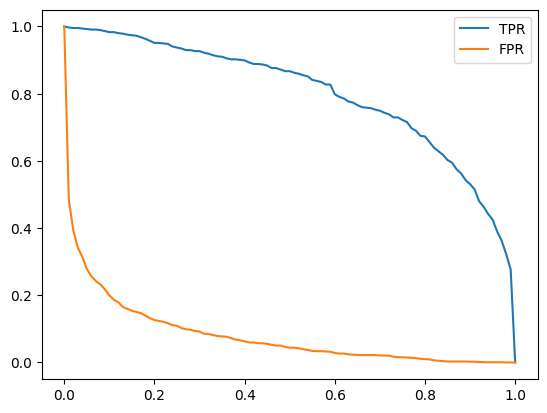

In [169]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [170]:
df_scores['f1'] = (2* df_scores.tpr * df_scores.fpr)/(df_scores.tpr + df_scores.fpr)

Text(0.5, 1.0, 'F1 Score')

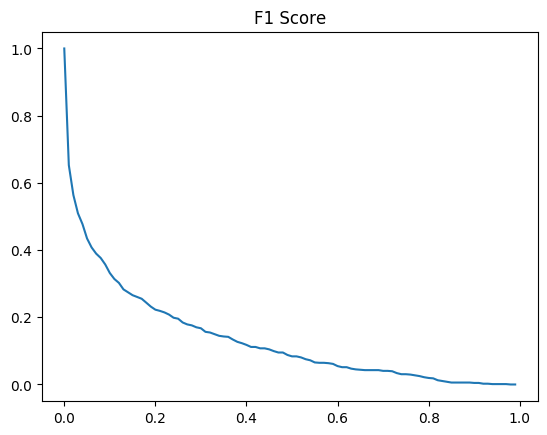

In [171]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.title('F1 Score')

In [172]:
df_scores[df_scores.f1 == max(df_scores.f1)]

,threshold,tp,fp,fn,tn,tpr,fpr,f1
0,0.0,654,1729,0,0,1.0,1.0,1.0


## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [173]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [177]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_X_full):
    df_train = df_X_full.iloc[train_idx]
    df_val = df_X_full.iloc[val_idx]

    y_train = df_train.price
    y_val = df_val.price

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

1.000 +- 0.000


## Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [179]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_X_full):
        df_train = df_X_full.iloc[train_idx]
        df_val = df_X_full.iloc[val_idx]

        y_train = df_train.price
        y_val = df_val.price

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.998 +- 0.001
C= 0.1, 1.000 +- 0.000
C=   1, 1.000 +- 0.000
C=  10, 1.000 +- 0.000
